In [ ]:
import numpy as np
import torch
import cv2
import os
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

## download

In [ ]:
!wget https://zenodo.org/records/3697452/files/LabPicsV1.zip?download=1

--2024-11-09 13:52:18--  https://zenodo.org/records/3697452/files/LabPicsV1.zip?download=1
Resolving zenodo.org (zenodo.org)... 188.184.103.159, 188.184.98.238, 188.185.79.172, ...
Connecting to zenodo.org (zenodo.org)|188.184.103.159|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2960213543 (2.8G) [application/octet-stream]
Saving to: ‘LabPicsV1.zip?download=1’

LabPicsV1.zip?downl 100%[===================>]   2.76G  19.5MB/s    in 3m 9s   

2024-11-09 13:55:28 (14.9 MB/s) - ‘LabPicsV1.zip?download=1’ saved [2960213543/2960213543]



In [ ]:
import zipfile

zip_path = '/localhome/aaa324/CMPT742/A9/LabPicsV1.zip'
extract_path = 'LabPicsV1/'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

## Train

In [ ]:
data_dir=r"LabPicsV1//LabPicsV1//" # Path to LabPics1 dataset folder
data=[] # list of files in dataset
for ff, name in enumerate(os.listdir(data_dir+"Simple/Train/Image/")):  # go over all folder annotation
    data.append({"image":data_dir+"Simple/Train/Image/"+name,"annotation":data_dir+"Simple/Train/Instance/"+name[:-4]+".png"})

In [ ]:
def read_batch(data): # read random image and its annotaion from  the dataset (LabPics)

   #  select image

        ent  = data[np.random.randint(len(data))] # choose random entry
        Img = cv2.imread(ent["image"])[...,::-1]  # read image
        ann_map = cv2.imread(ent["annotation"]) # read annotation

   # resize image

        r = np.min([1024 / Img.shape[1], 1024 / Img.shape[0]]) # scalling factor
        Img = cv2.resize(Img, (int(Img.shape[1] * r), int(Img.shape[0] * r)))
        ann_map = cv2.resize(ann_map, (int(ann_map.shape[1] * r), int(ann_map.shape[0] * r)),interpolation=cv2.INTER_NEAREST)

   # merge vessels and materials annotations

        mat_map = ann_map[:,:,0] # material annotation map
        ves_map = ann_map[:,:,2] # vessel  annotaion map
        mat_map[mat_map==0] = ves_map[mat_map==0]*(mat_map.max()+1) # merged map

   # Get binary masks and points

        inds = np.unique(mat_map)[1:] # load all indices
        points= []
        masks = []
        for ind in inds:
            mask=(mat_map == ind).astype(np.uint8) # make binary mask
            masks.append(mask)
            coords = np.argwhere(mask > 0) # get all coordinates in mask
            yx = np.array(coords[np.random.randint(len(coords))]) # choose random point/coordinate
            points.append([[yx[1], yx[0]]])
        return Img,np.array(masks),np.array(points), np.ones([len(masks),1])

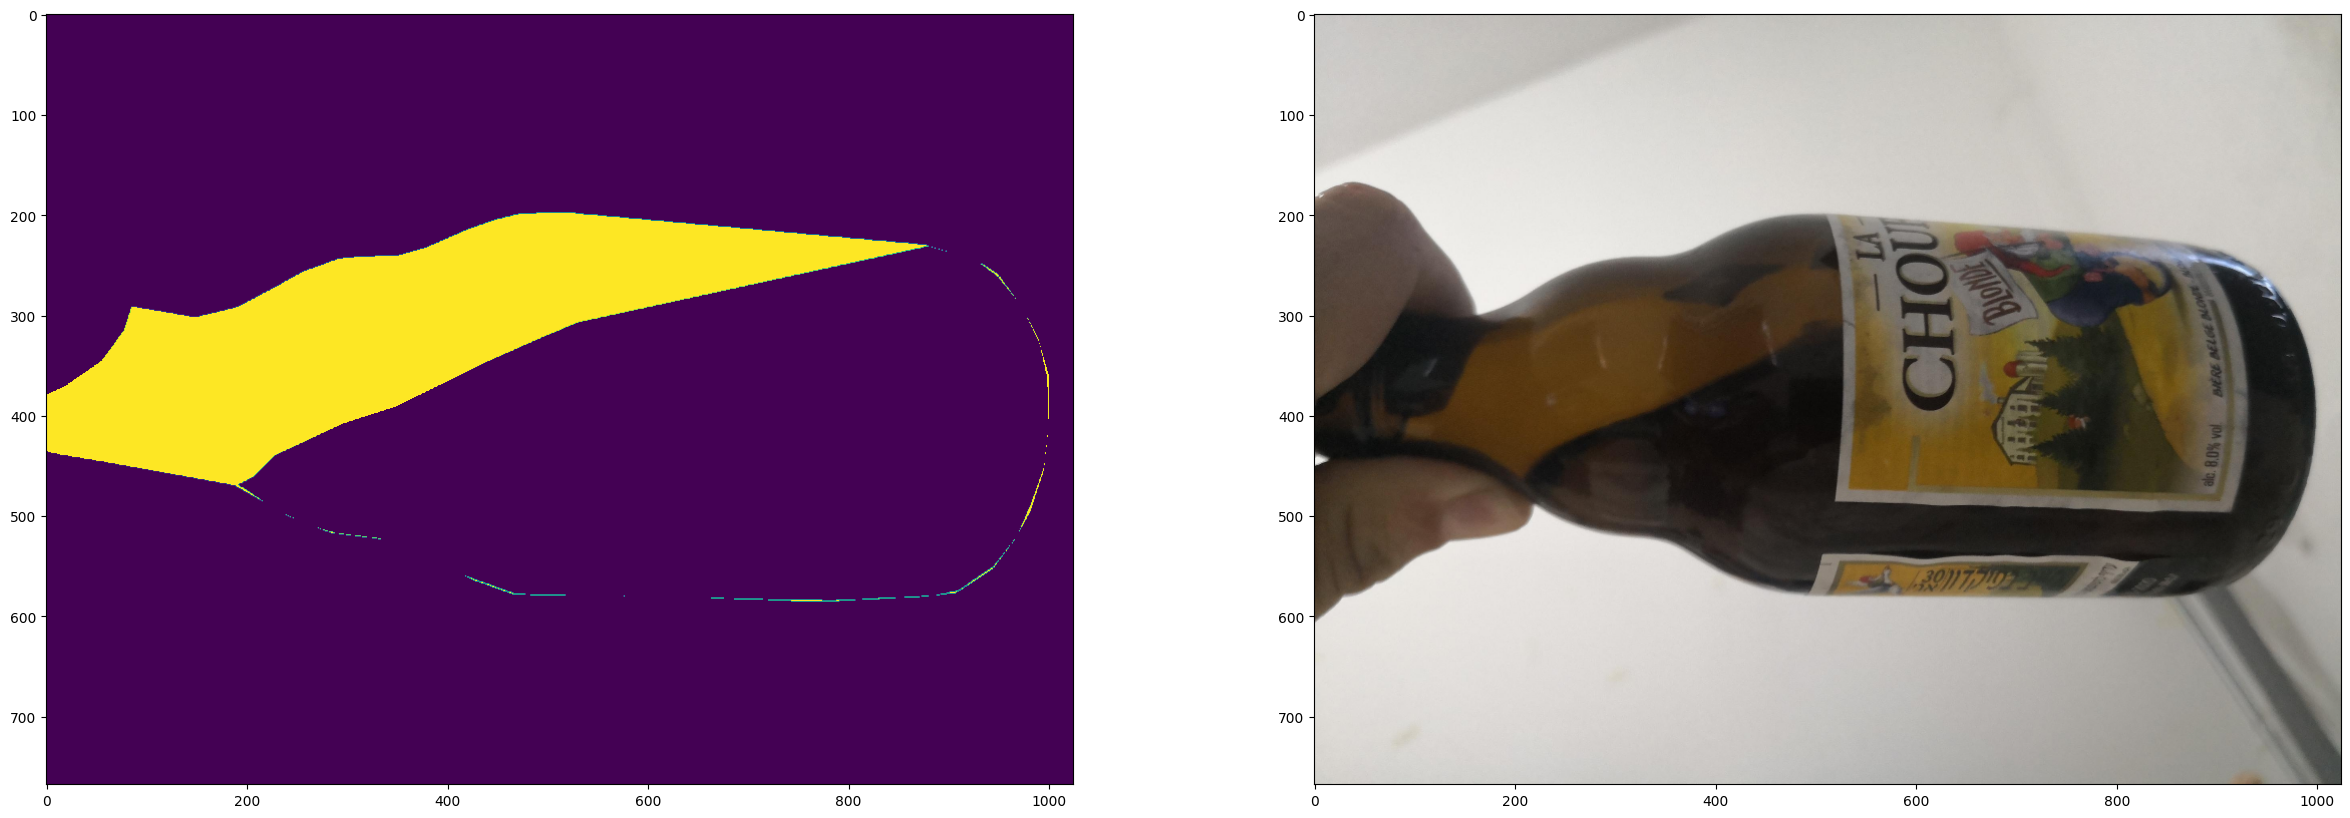

In [ ]:
from matplotlib import pyplot as plt

x = read_batch(data)
fig ,axes = plt.subplots(nrows=1, ncols=2, figsize=(30,10))
axes[0].imshow(x[1][1])
axes[1].imshow(x[0])

In [ ]:
sam2_checkpoint = "sam2_hiera_small.pt" # path to model weight
model_cfg = "sam2_hiera_s.yaml" # model config
sam2_model = build_sam2(model_cfg, sam2_checkpoint, device="cuda") # load model
predictor = SAM2ImagePredictor(sam2_model) # load net

In [ ]:
predictor.model.sam_mask_decoder.train(True) # enable training of mask decoder
predictor.model.sam_prompt_encoder.train(True) # enable training of prompt encoder

PromptEncoder(
  (pe_layer): PositionEmbeddingRandom()
  (point_embeddings): ModuleList(
    (0-3): 4 x Embedding(1, 256)
  )
  (not_a_point_embed): Embedding(1, 256)
  (mask_downscaling): Sequential(
    (0): Conv2d(1, 4, kernel_size=(2, 2), stride=(2, 2))
    (1): LayerNorm2d()
    (2): GELU(approximate='none')
    (3): Conv2d(4, 16, kernel_size=(2, 2), stride=(2, 2))
    (4): LayerNorm2d()
    (5): GELU(approximate='none')
    (6): Conv2d(16, 256, kernel_size=(1, 1), stride=(1, 1))
  )
  (no_mask_embed): Embedding(1, 256)
)

In [ ]:
optimizer=torch.optim.AdamW(params=predictor.model.parameters(),lr=1e-5,weight_decay=4e-5)

In [ ]:
scaler = torch.cuda.amp.GradScaler() # set mixed precision

In [ ]:
for itr in range(400):
    with torch.cuda.amp.autocast(): # cast to mix precision
            image,mask,input_point, input_label = read_batch(data) # load data batch
            if mask.shape[0]==0: continue # ignore empty batches
            predictor.set_image(image) # apply SAM image encoder to the image
            print(11,input_point.shape, input_label.shape, mask.shape)
            mask_input, unnorm_coords, labels, unnorm_box = predictor._prep_prompts(input_point, input_label, box=None, mask_logits=None, normalize_coords=True)
            print(unnorm_coords.shape, labels.shape)
            sparse_embeddings, dense_embeddings = predictor.model.sam_prompt_encoder(points=(unnorm_coords, labels),boxes=None,masks=None,)
            batched_mode = unnorm_coords.shape[0] > 1 # multi mask prediction
            high_res_features = [feat_level[-1].unsqueeze(0) for feat_level in predictor._features["high_res_feats"]]
            low_res_masks, prd_scores, _, _ = predictor.model.sam_mask_decoder(image_embeddings=predictor._features["image_embed"][-1].unsqueeze(0),image_pe=predictor.model.sam_prompt_encoder.get_dense_pe(),sparse_prompt_embeddings=sparse_embeddings,dense_prompt_embeddings=dense_embeddings,multimask_output=True,repeat_image=batched_mode,high_res_features=high_res_features,)
            prd_masks = predictor._transforms.postprocess_masks(low_res_masks, predictor._orig_hw[-1])# Upscale the masks to the original image resolution
            gt_mask = torch.tensor(mask.astype(np.float32)).cuda()
            prd_mask = torch.sigmoid(prd_masks[:, 0])# Turn logit map to probability map
            seg_loss = (-gt_mask * torch.log(prd_mask + 0.00001) - (1 - gt_mask) * torch.log((1 - prd_mask) + 0.00001)).mean() # cross entropy loss
            inter = (gt_mask * (prd_mask > 0.5)).sum(1).sum(1)
            iou = inter / (gt_mask.sum(1).sum(1) + (prd_mask > 0.5).sum(1).sum(1) - inter)
            score_loss = torch.abs(prd_scores[:, 0] - iou).mean()
            loss = seg_loss+score_loss*0.05  # mix losses
            predictor.model.zero_grad() # empty gradient
            scaler.scale(loss).backward()  # Backpropogate
            scaler.step(optimizer)
            scaler.update() # Mix precision
            if itr==0:
                mean_iou=0
            mean_iou = mean_iou * 0.99 + 0.01 * np.mean(iou.cpu().detach().numpy())
            print("step)",itr, "Accuracy(IOU)=",mean_iou)
            if itr%100==0: torch.save(predictor.model.state_dict(), "model.torch") # save model

11 (10, 1, 2) (10, 1) (10, 1024, 1024)
torch.Size([10, 1, 2]) torch.Size([10, 1])
step) 0 Accuracy(IOU)= 0.005470185279846191
11 (3, 1, 2) (3, 1) (3, 575, 1024)
torch.Size([3, 1, 2]) torch.Size([3, 1])
step) 1 Accuracy(IOU)= 0.010675118279457092
11 (2, 1, 2) (2, 1) (2, 575, 1024)
torch.Size([2, 1, 2]) torch.Size([2, 1])
step) 2 Accuracy(IOU)= 0.015764752480268478
11 (5, 1, 2) (5, 1) (5, 575, 1024)
torch.Size([5, 1, 2]) torch.Size([5, 1])
step) 3 Accuracy(IOU)= 0.020297212360651493
11 (3, 1, 2) (3, 1) (3, 768, 1024)
torch.Size([3, 1, 2]) torch.Size([3, 1])
step) 4 Accuracy(IOU)= 0.024593982327747035
11 (2, 1, 2) (2, 1) (2, 576, 1024)
torch.Size([2, 1, 2]) torch.Size([2, 1])
step) 5 Accuracy(IOU)= 0.028607295350710563
11 (6, 1, 2) (6, 1) (6, 575, 1024)
torch.Size([6, 1, 2]) torch.Size([6, 1])
step) 6 Accuracy(IOU)= 0.034068965050096524
11 (10, 1, 2) (10, 1) (10, 682, 1024)
torch.Size([10, 1, 2]) torch.Size([10, 1])
step) 7 Accuracy(IOU)= 0.041792019110113446
11 (4, 1, 2) (4, 1) (4, 1024,

KeyboardInterrupt: 

## Test

In [ ]:
import numpy as np
import torch
import cv2
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

In [ ]:
# torch.autocast(device_type="cuda", dtype=torch.bfloat16).__enter__()
def read_batch2(data): # read random image and its annotaion from  the dataset (LabPics)
#  select image
    ent  = data[np.random.randint(len(data))] # choose random entry
    Img = cv2.imread(ent["image"])[...,::-1]  # read image
    ann_map = cv2.imread(ent["annotation"]) # read annotation

# resize image
    r = np.min([1024 / Img.shape[1], 1024 / Img.shape[0]]) # scalling factor
    Img = cv2.resize(Img, (int(Img.shape[1] * r), int(Img.shape[0] * r)))
    ann_map = cv2.resize(ann_map, (int(ann_map.shape[1] * r), int(ann_map.shape[0] * r)),interpolation=cv2.INTER_NEAREST)

    return Img, ann_map
image, mask = read_batch2(data)


In [ ]:
num_samples = 30 # number of points/segment to sample
def get_points(mask,num_points): # Sample points inside the input mask
        points=[]
        for i in range(num_points):
            coords = np.argwhere(mask > 0)
            yx = np.array(coords[np.random.randint(len(coords))])
            points.append([[yx[1], yx[0]]])
        return np.array(points)
input_points = get_points(mask,num_samples)

In [ ]:
# Load model you need to have pretrained model already made
sam2_checkpoint = "sam2_hiera_small.pt"
model_cfg = "sam2_hiera_s.yaml"
sam2_model = build_sam2(model_cfg, sam2_checkpoint, device="cuda")
predictor = SAM2ImagePredictor(sam2_model)

In [ ]:
predictor.model.load_state_dict(torch.load("model.torch"))

<All keys matched successfully>

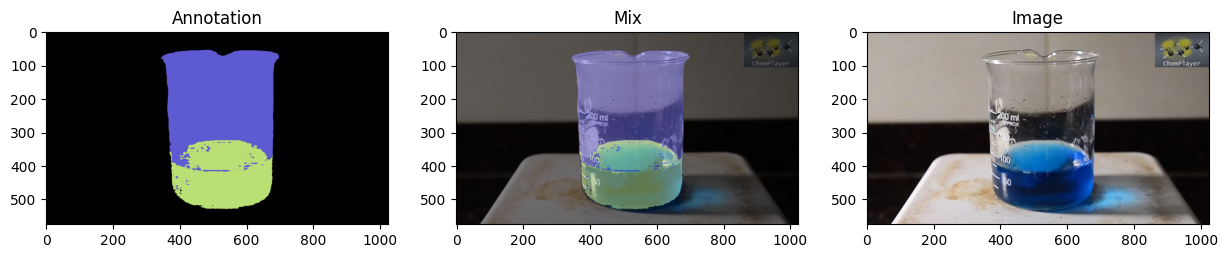

In [ ]:
from matplotlib import pyplot as plt

with torch.no_grad(): # prevent the net from caclulate gradient (more efficient inference)
    predictor.set_image(image) # image encoder
    masks, scores, logits = predictor.predict(  # prompt encoder + mask decoder
        point_coords=input_points,
        point_labels=np.ones([input_points.shape[0],1])
    )
masks=masks[:,0].astype(bool)
shorted_masks = masks[np.argsort(scores[:,0])][::-1].astype(bool)
seg_map = np.zeros_like(shorted_masks[0],dtype=np.uint8)
occupancy_mask = np.zeros_like(shorted_masks[0],dtype=bool)
for i in range(shorted_masks.shape[0]):
    mask = shorted_masks[i]
    if (mask*occupancy_mask).sum()/mask.sum()>0.15: continue
    mask[occupancy_mask]=0
    seg_map[mask]=i+1
    occupancy_mask[mask]=1
rgb_image = np.zeros((seg_map.shape[0], seg_map.shape[1], 3), dtype=np.uint8)
for id_class in range(1,seg_map.max()+1):
    rgb_image[seg_map == id_class] = [np.random.randint(255), np.random.randint(255), np.random.randint(255)]


plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(rgb_image)
plt.title("Annotation")

plt.subplot(1, 3, 2)
plt.imshow((rgb_image / 2 + image / 2).astype(np.uint8))
plt.title("Mix")

plt.subplot(1, 3, 3)
plt.imshow(image)
plt.title("Image")

plt.show()